# Neural Network

- Recognize handwritten digits: neural network
- Data: 20 pixel by 20 pixel grayscale images
- Label: 1-10 ("0" digit is labeled as "10")



1. [Load Data](#data)
2. [Visualize Data](#plot)
3. [Helper Functions](#helper)
4. [Initialization of Parameters](#params)
4. [Regularized Cost Function](#cost)
5. [Gradient](#grad)
6. [Model](#model)
7. [Make Predictions](#predict)

## Load Data <a name="data"></a>

In [1]:
%pylab inline
from scipy.io import loadmat
import pylab

Populating the interactive namespace from numpy and matplotlib


In [2]:
dat = loadmat('dataset/ex4data1.mat')
X = dat['X']; y = np.squeeze(dat['y'])
y[y == 10] = 0
p = X.shape[1]
N = len(y)
print("Number of examples: {}".format(N))
print("Number of features: {}".format(p))
print("Shape of X: {}".format(X.shape))
print("Shape of y: {}".format(y.shape))

Number of examples: 5000
Number of features: 400
Shape of X: (5000, 400)
Shape of y: (5000,)


## Visualize Data <a name="plot"></a>

- Randomly select 100 examples to display

In [3]:
from numpy.random import choice
randSample = X[choice(N, size = 100)]

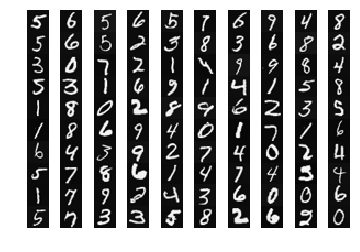

In [4]:
for i in range(100):
    plt.subplot(10, 10, i + 1)
    a = reshape(randSample[i], (20, 20)).T
    plt.imshow(a, cmap = plt.get_cmap('gray'))
    plt.axis('off')
plt.subplots_adjust(wspace = 0, hspace = 0)
plt.show()

## Helper Functions <a name="helper"></a>
- Add intercept

In [5]:
def addintercept(X):
    N = X.shape[0]
    X = np.hstack((np.ones((N, 1)), X))
    return X

- Sigmoid function

In [6]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

- Sigmoid gradient

In [7]:
def sigmoidGrad(z):
    s = sigmoid(z)
    return s * (1 - s)

- dummy output

In [8]:
def dummy(y, K):
    # number of examples
    N = y.shape[0]
    Y = np.zeros((N, K))
    for row in range(N):
        Y[row, y[row]] = 1
    return Y

## Initialization of Parameters <a name="params"></a>

In [9]:
def initialParams(layerDims):
    # number of layers
    L = len(layerDims)
    
    Theta = {}
    for i in range(1, L):
        size = (layerDims[i], layerDims[i - 1] + 1)
        epsilon = np.sqrt(6/(layerDims[i] + layerDims[i - 1]))
        Theta[i] = np.random.uniform(low = -epsilon, high = epsilon, size = size)
    return Theta

## Regularized Cost Function <a name="cost"></a>

$$
J(\Theta)=-\frac{1}{N}\sum_{i=1}^N\sum_{k=1}^K\left[y_{k}^{(i)}\log h_{\Theta}(x^{(i)})_k +(1-y_{k}^{(i)})\log (1-h_{\Theta}(x^{(i)})_k)\right]+\frac{\lambda}{2N}\sum_{l=1}^{L-1}\sum_{i=1}^{s_l}\sum_{j=1}^{s_{l+1}}(\Theta_{ji}^{(l)})^2
$$

## Gradient <a name = "grad"></a>

$N$ training examples:

- $\Delta^{[L]}=A^{[L]}-Y$
- $\Delta^{[\ell]}=\Delta^{[\ell+1]}\tilde{\Theta}^{[\ell]}*g'(Z^{[\ell]}), \ \ \ell=L-1,\ldots,2$, where $\tilde{\Theta}=\Theta$ without the first column
- Gradient of $\Theta^{[\ell]}$: 
$$
D^{[\ell]}=\frac{1}{N}\Delta^{[\ell+1]T}A^{[\ell]}+\frac{\lambda}{N}\hat{\Theta}^{[\ell]},\text{ where } \hat{\Theta}^{[\ell]}=\Theta^{[\ell]}  \text{ with first column being all 0}
$$

In [10]:
def nnCost(X, Y, Theta, lmbd):
    # number of layers
    L = len(Theta) + 1
    
    Z = {}; A = {}; A[1] = addintercept(X)
    gradZ = {}; gradTheta = {}
    
    # number of examples
    N = X.shape[0]
    
    # forward propagation
    for i in range(2, L + 1):
        Z[i] = np.dot(A[i - 1], Theta[i - 1].T) # linear forward
        A[i] = sigmoid(Z[i])
        if i < L:
            A[i] = addintercept(A[i])
        
    # cost
    reg = sum(sum(np.power(Theta[k][:, 1:], 2)) for k in Theta)
    J = sum(-Y * np.log(A[L]) - (1 - Y) * np.log(1 - A[L]))/N + lmbd * reg/2/N
    
    # backward propagation
    for i in range(L, 1, -1):
        # gradient of Z
        if i == L:
            gradZ[i] = A[L] - Y
        else:
            Theta_temp = Theta[i][:, 1:]
            gradZ[i] = np.dot(gradZ[i + 1], Theta_temp) * sigmoidGrad(Z[i])
            
        # gradient of parameters
        Theta_temp2 = np.copy(Theta[i - 1])
        Theta_temp2[:, 0] = 0
        gradTheta[i - 1] = np.dot(gradZ[i].T, A[i - 1])/N + lmbd * Theta_temp2/N     
   
    return J, gradTheta

## Model <a name="model"></a>

In [11]:
def nnModel(X, y, layerDims, learning_rate = 2, num_iterations = 500, lmbd = 1):
    costs = []
    
    # initialize parameters
    Theta = initialParams(layerDims)
    
    # number of layers
    L = len(Theta) + 1
    
    # number of output layer nodes
    K = Theta[L - 1].shape[0]
    
    # dummy output
    Y = dummy(y, K)
    
    for i in range(num_iterations):
        cost, grad = nnCost(X, Y, Theta, lmbd)
        if i % 50 == 0:
            print("Cost after iteration %i: %f" %(i, cost))
            costs.append(cost)
        
        # update parameters
        for k in Theta:
            Theta[k] -= learning_rate * grad[k]
    
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return Theta            

Cost after iteration 0: 8.241190
Cost after iteration 50: 1.428199
Cost after iteration 100: 0.949520
Cost after iteration 150: 0.773019
Cost after iteration 200: 0.685425
Cost after iteration 250: 0.631741
Cost after iteration 300: 0.594192
Cost after iteration 350: 0.566382
Cost after iteration 400: 0.544681
Cost after iteration 450: 0.527130


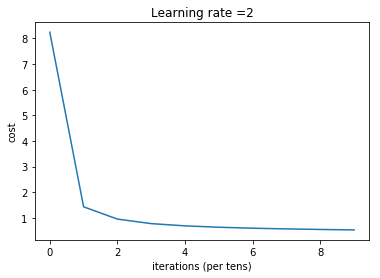

In [12]:
layerDims = [400, 25, 10]
Theta = nnModel(X, y, layerDims)

## Make Predictions <a name="predict"></a>

In [13]:
def nnPredict(Theta, X):
    # number of layers
    L = len(Theta) + 1
    
    Z = {}; A = {}; A[1] = addintercept(X)
    # forward propagation
    for i in range(2, L + 1):
        Z[i] = np.dot(A[i - 1], Theta[i - 1].T) # linear forward
        A[i] = sigmoid(Z[i])
        if i < L:
            A[i] = addintercept(A[i])
    # one-vs-all prediction
    return np.argmax(A[L], axis = 1)

In [14]:
pred = nnPredict(Theta, X)
print("Accuracy: {}%".format(np.mean(pred == y)*100))

Accuracy: 95.12%
